In [1]:
!pip install object-detection-fastai

  Created wheel for object-detection-fastai: filename=object_detection_fastai-0.0.6-py3-none-any.whl size=31578 sha256=062a9309ab48cdcd0d145c909878b843b473be1039884972c81906cb76b4e86d
  Stored in directory: /root/.cache/pip/wheels/1c/75/24/07b3216684aab3be20acdb86d1f9fcdf3ee57a307797d9b8a9
Successfully built object-detection-fastai
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
from tqdm.notebook import tqdm
from xml.etree.ElementTree import parse
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as immg
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold,KFold

from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [3]:
path = '../input/hard-hat-detection/annotations'
path_img = '../input/hard-hat-detection/images'

In [4]:
file_xml = []
for file in os.listdir(path):
    if '.xml' in file:
        file_xml.append(file)

## Processing xml files :
* For **BBOXs** and **Labels**

In [5]:
hat = []
labels = []
object_xmin=[]
object_ymin=[]
object_xmax=[]
object_ymax=[]
for i in tqdm(range(len(file_xml))):
    name = file_xml[i]
    hat.append(name[:-4])
    objects = parse(os.path.join(path,file_xml[i])).findall('object')
    object_xmin.append([int(x.find("bndbox").findtext("xmin")) for x in objects])
    object_ymin.append([int(x.find("bndbox").findtext("ymin")) for x in objects])
    object_xmax.append([int(x.find("bndbox").findtext("xmax")) for x in objects])
    object_ymax.append([int(x.find("bndbox").findtext("ymax")) for x in objects])
    labels.append([x.findtext('name') for x in objects])

In [6]:
df = pd.DataFrame({'file_name':hat,'xmin':object_xmin,'ymin':object_ymin,
                                   'xmax':object_xmax,'ymax':object_ymax,'labels':labels})

In [7]:
path1 = Path('../input/hard-hat-detection')

## Function to get BBOXs

In [8]:
def image_lbl(df):
    hat2bbox = {}
    for i in tqdm(range(df.shape[0])):
        bbox = []
        lbl =[]
        title = []
        a = df.iloc[i][1:-1].values
        l = df.iloc[i][-1]
        for j in range(len(l)):
            bbx = [x[j] for x in a]
            if l[j]!='person':
                bbx = [bbx[1],bbx[0],bbx[3],bbx[2]]
                lbl.append(bbx)
                title.append(l[j])
        bbox.append(lbl)
        bbox.append(title)
        hat2bbox[df.iloc[i][0]+'.png'] = bbox
    return hat2bbox

In [9]:
hat2bbox = image_lbl(df)

## Sample Image

In [10]:
def show_sam(n):
    name = df.iloc[n][0] + '.png'
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(immg.imread(os.path.join(path_img,name)))
    B = hat2bbox[name]
    for l,bbox in zip(B[1],B[0]):
        bbox = [bbox[1],bbox[0],bbox[3],bbox[2]]
        bbox[2] = abs(bbox[0]-bbox[2])
        bbox[3] = abs(bbox[1]-bbox[3])
        draw_rect(ax,bbox,text=l)
    plt.axis('off')

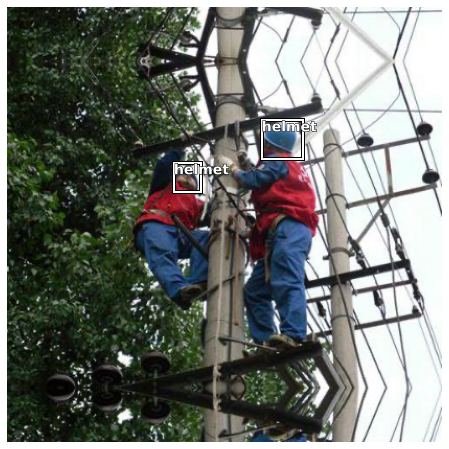

In [11]:
show_sam(random.randint(2,4800))

### Function to get bbox for each image

In [12]:
get_y_func = lambda o: hat2bbox[Path(o).name] 

In [13]:
tfms = get_transforms()
size = 512

## DataBunch

In [14]:
data = (ObjectItemList.from_df(df,path1, folder = 'images' , suffix = '.png',cols='file_name')
        #Where are the images? ->
        .split_by_rand_pct(0.2)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(size=size,tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=8, collate_fn=bb_pad_collate))  

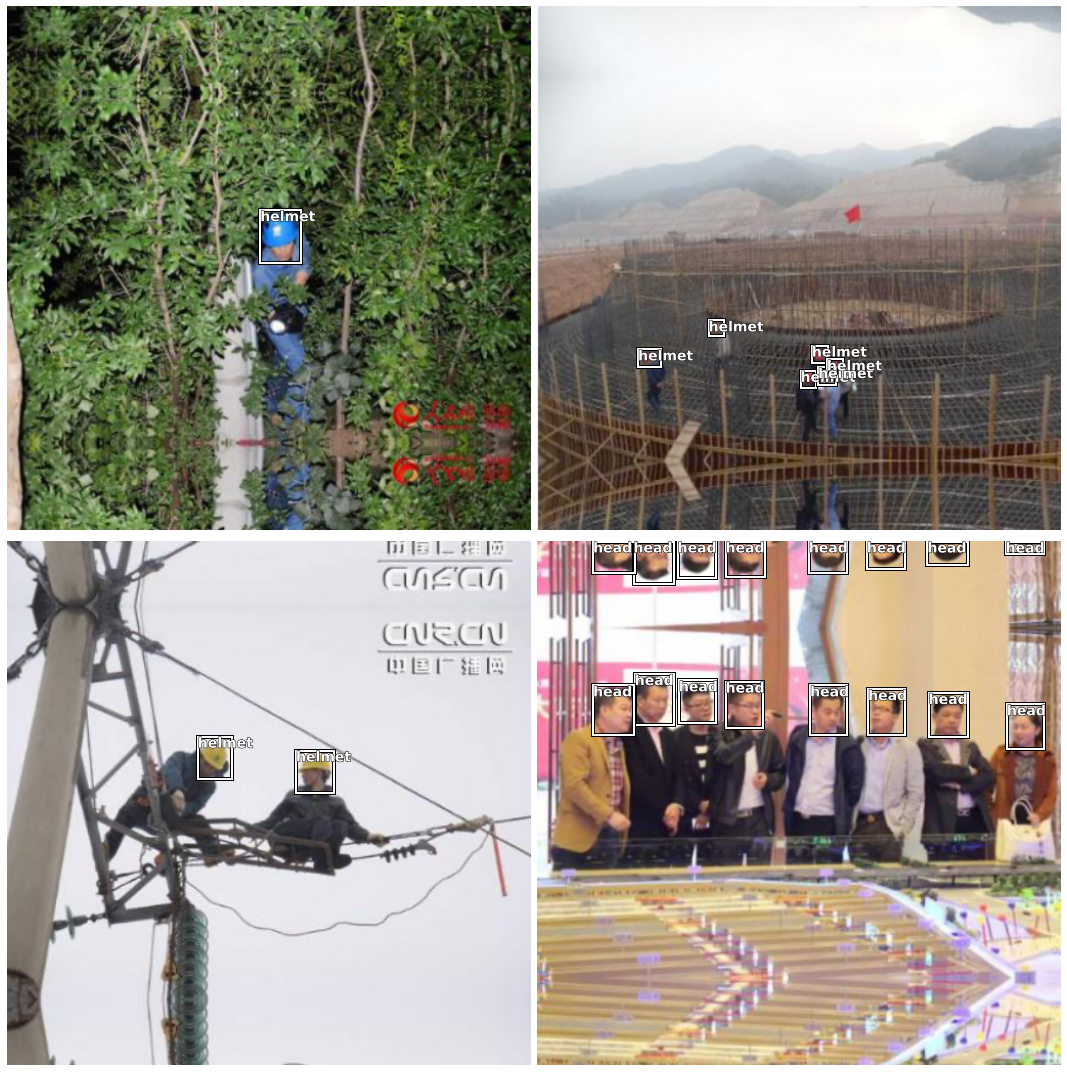

In [15]:
data.show_batch(rows=2,  figsize=(15,15))

In [16]:
len(data.train_ds),len(data.valid_ds),data.classes

(4000, 1000, ['background', 'head', 'helmet'])

In [17]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.3, 0.6, 1.2, 2, 2.8, 3.4,])
#anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.4, 0.6, 0.85, 1, 1.6, 1.8])

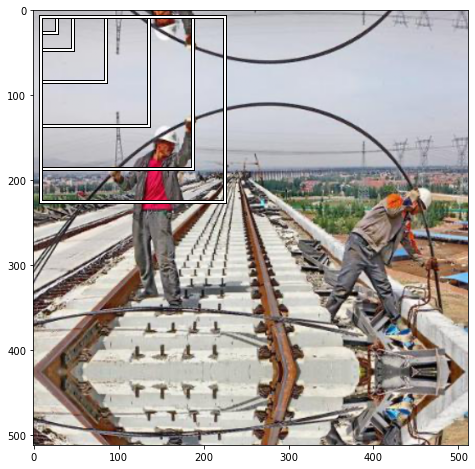

In [18]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:6]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [19]:
len(anchors)

6144

In [20]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=6, sizes=[32], chs=32, final_bias=-4., n_conv=3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [21]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, 
                loss_func=crit, 
                callback_fns=[BBMetrics],
                metrics=[voc],
               model_dir='/kaggle/working/')

In [22]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [23]:
#learn.lr_find()
#learn.recorder.plot()

In [24]:
gc.collect()

11712

In [25]:
learn.fit_one_cycle(3, 1e-3 , callbacks = [ SaveModelCallback(learn, every ='improvement', monitor = 'AP-helmet', name = 'best_model' ) ] )

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
GT: 100%|██████████| 3921/3921 [00:03<00:00, 1025.11it/s]


Better model found at epoch 0 with AP-helmet value: 0.5870340031402114.


GT: 100%|██████████| 3926/3926 [00:04<00:00, 972.55it/s]


Better model found at epoch 1 with AP-helmet value: 0.6720813098937672.


GT: 100%|██████████| 3922/3922 [00:03<00:00, 1211.75it/s]


Better model found at epoch 2 with AP-helmet value: 0.7046250602405726.


In [26]:
learn.load('best_model');
learn.export('/kaggle/working/safetyHelmet.pkl');

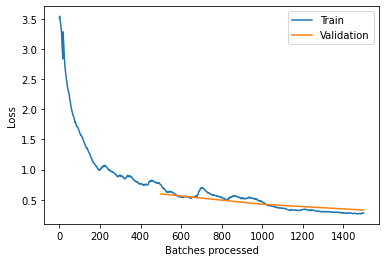

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, callbacks = [SaveModelCallback(learn, every ='improvement', monitor ='AP-helmet', name ='best_model_ft')] )

GT: 100%|██████████| 3892/3892 [00:02<00:00, 1346.73it/s]


Better model found at epoch 0 with AP-helmet value: 0.6709853235414415.


GT: 100%|██████████| 3908/3908 [00:02<00:00, 1335.02it/s]


Better model found at epoch 5 with AP-helmet value: 0.6804365365059695.


GT: 100%|██████████| 3908/3908 [00:03<00:00, 1142.96it/s]


Better model found at epoch 6 with AP-helmet value: 0.7029554427546522.


GT: 100%|██████████| 3910/3910 [00:02<00:00, 1396.01it/s]


Better model found at epoch 7 with AP-helmet value: 0.7049858347780857.


GT: 100%|██████████| 3878/3878 [00:02<00:00, 1441.59it/s]


In [29]:
learn.load('best_model_ft');
learn.export('/kaggle/working/safetyHelmet_ft.pkl');

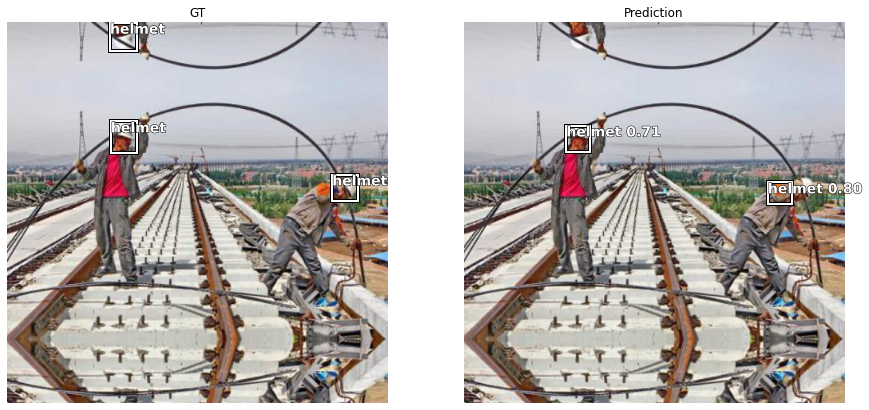

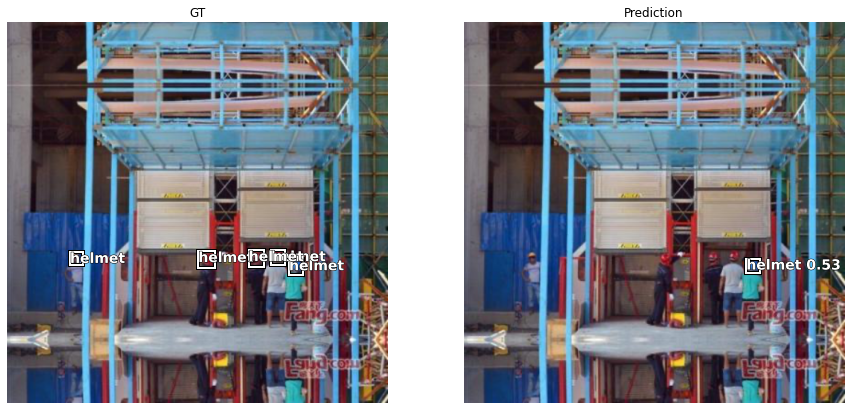

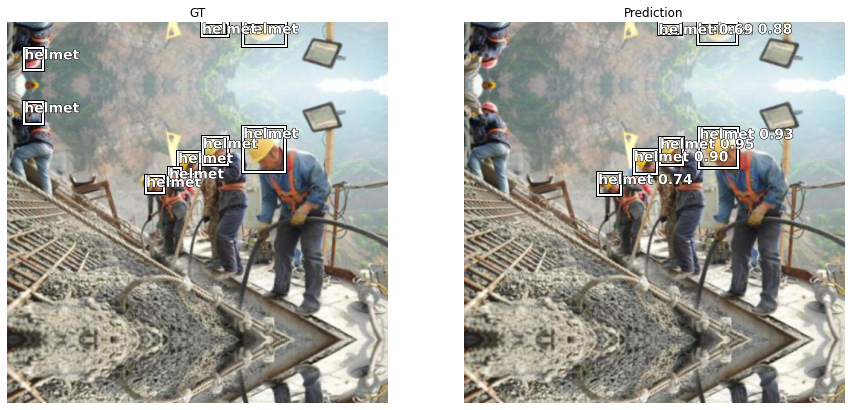

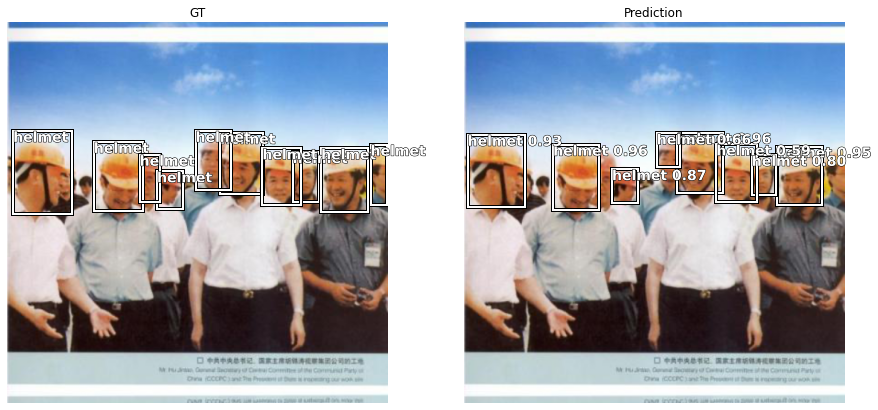

In [30]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=4)